# Next Pitch Prediction using Transformers

The final experiment in the series is using Transformers for predicting the next pitch's type and location. The model is trained on the same dataset as the previous experiments. A Transformer is a deep learning model that adopts the self-attention mechanism to draw global dependencies between input and output. The model is trained on the sequence of pitches and their locations. The model is then used to predict the next pitch's type and location given the sequence of pitches.

## Data loading and sequencing

In [10]:
import os
import tensorflow as tf
import keras_tuner


from utils.plot_utils import smooth_curve
import matplotlib.pyplot as plt
from utils.plot_utils import plot_ensemble_history
from utils.callbacks import FreezeOutputCallback

os.chdir('../..')
tf.keras.utils.set_random_seed(42)

The first step is to load the pitch data and sequence it into a format that can be used to train the LSTM. For this, the preprocessing utils developed earlier will be used.

It is also necessary to split the data into training, validation and test sets. A 60-20-20 split will be done using Scikit Learn.

In [2]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley_15-21.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=42)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

## Baseline Transformer model

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, activation='relu', dropout=0, return_sequences=True, reg=None):
    # Attention and Normalization
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation, kernel_regularizer=reg)(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, kernel_regularizer=reg)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = x + res

    if not return_sequences:
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    return x

In [4]:
def build_network(input_layer, num_targets, name='', num_hidden_layers=1, activation='relu', reg=None, dropout=0, head_size=256, num_heads=4, ff_dim=128):
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, activation=activation, reg=reg, dropout=dropout)

    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, return_sequences=False)
    
    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=f'{name}_output')(x)

    return outputs


In [ ]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                                 num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                 activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                 head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                 num_heads=hp.Int('num_heads', min_value=2, max_value=6, step=2),
                                 ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                                    num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                    activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                    head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                    num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
                                    ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                                      num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                      activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                      head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                      num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
                                      ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[
                                           pitch_output, vertical_output, horizontal_output])

    # Compile the model
    ensemble_model.compile(optimizer='adam',
                           loss={'pitch_output': 'categorical_crossentropy',
                                 'vertical_output': 'categorical_crossentropy',
                                 'horizontal_output': 'categorical_crossentropy'},
                           metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [ ]:
freeze_output_callback = FreezeOutputCallback(patience=5)

In [16]:
# Create an instance of the HyperParameters object
hp = keras_tuner.HyperParameters()

# Test the build_model function
model = build_model(hp)

# Train the model
history = model.fit(X_train, 
                    {'pitch_output': y_pitch_train,
                     'vertical_output': y_vertical_train,
                     'horizontal_output': y_horizontal_train},
                    epochs=100, batch_size=64, 
                    validation_data=(X_val, 
                                     {'pitch_output': y_pitch_val,
                                      'vertical_output': y_vertical_val,
                                      'horizontal_output': y_horizontal_val}),
                    callbacks=[freeze_output_callback],
                             verbose=1
                    )

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - horizontal_output_accuracy: 0.4879 - loss: 3.7325 - pitch_output_accuracy: 0.3141 - vertical_output_accuracy: 0.6250 - val_horizontal_output_accuracy: 0.5112 - val_loss: 3.4182 - val_pitch_output_accuracy: 0.3563 - val_vertical_output_accuracy: 0.6672
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - horizontal_output_accuracy: 0.5118 - loss: 3.4250 - pitch_output_accuracy: 0.3642 - vertical_output_accuracy: 0.6466 - val_horizontal_output_accuracy: 0.5178 - val_loss: 3.3998 - val_pitch_output_accuracy: 0.3660 - val_vertical_output_accuracy: 0.6672
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - horizontal_output_accuracy: 0.5167 - loss: 3.3974 - pitch_output_accuracy: 0.3761 - vertical_output_accuracy: 0.6465 - val_horizontal_output_accuracy: 0.5218 - val_loss: 3.3908 - val_pitch_output_accuracy: 0.3659 - val_vertical_output_accuracy: 0.6672
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - horizontal_output_accu

In [17]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - horizontal_output_accuracy: 0.6160 - loss: 3.1606 - pitch_output_accuracy: 0.4782 - vertical_output_accuracy: 0.7104
Pitch Test Accuracy: 0.6102362275123596
Vertical Test Accuracy: 0.47598424553871155
Horizontal Test Accuracy: 0.7137795090675354


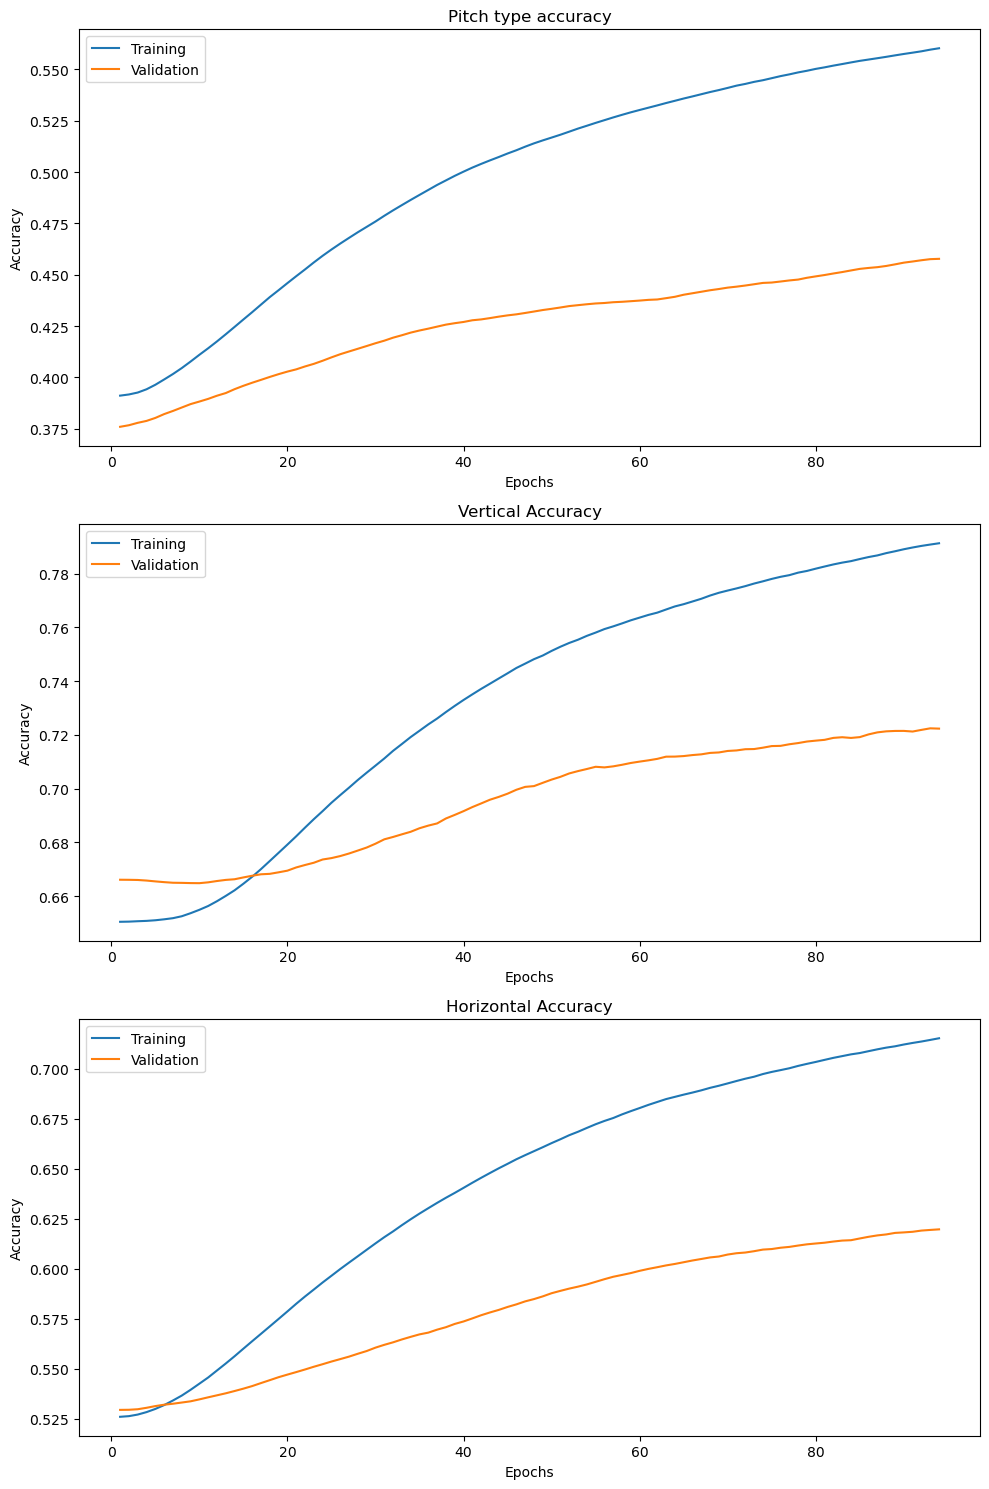

In [18]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

## Bayesian Optimization to get best hyperparameters

In [7]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=10,
    project_name='Transformers_Ensemble'
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=100, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[freeze_output_callback],
            )

Trial 10 Complete [00h 08m 42s]
multi_objective: -2.039107620716095

Best multi_objective So Far: -2.148031532764435
Total elapsed time: 02h 58m 34s


In [10]:
import pandas as pd

# Get the tuner results
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Extract relevant information
results = []
for trial in tuner_results:
    trial_summary = {
        'Trial ID': trial.trial_id,
        'Hidden layers': trial.hyperparameters.values['num_hidden_layers'],
        'Head size': trial.hyperparameters.values['head_size'],
        'Number of heads': trial.hyperparameters.values['num_heads'],
        'Feed forward dimension': trial.hyperparameters.values['ff_dim'],
        'Activation': trial.hyperparameters.values['activation'],
        'Score': trial.score,
        'Pitch Accuracy': trial.metrics.get_last_value('val_pitch_output_accuracy'),
        'Vertical Accuracy': trial.metrics.get_last_value('val_vertical_output_accuracy'),
        'Horizontal Accuracy': trial.metrics.get_last_value('val_horizontal_output_accuracy')
    }
    results.append(trial_summary)

# Create a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('transformer_search_results.csv', index=False)

# Display the results
results_df

,Trial ID,Hidden layers,Head size,Number of heads,Feed forward dimension,Activation,Score,Pitch Accuracy,Vertical Accuracy,Horizontal Accuracy
0,06,2,64,4,256,relu,-2.148032,0.633990,0.790682,0.723360
1,07,3,32,6,128,tanh,-2.040157,0.600131,0.755118,0.684908
2,09,1,128,2,256,relu,-2.039108,0.572441,0.770997,0.695669
3,01,2,64,2,128,relu,-2.015879,0.587402,0.747638,0.680840
4,00,3,128,2,128,tanh,-1.995013,0.578084,0.748294,0.668635
5,04,1,64,2,256,relu,-1.968241,0.551181,0.753543,0.663517
6,05,2,128,4,256,sigmoid,-1.955512,0.567717,0.728346,0.659449
7,03,2,64,4,256,tanh,-1.952493,0.567585,0.722703,0.662205
8,08,1,256,4,128,sigmoid,-1.852231,0.481890,0.719029,0.651312
9,02,1,64,2,64,sigmoid,-1.761024,0.465879,0.710367,0.584777


We can see that Trial 06 obtained the best overall results by a good margin. We will use this trial as a basis for our final Transformer model.

In [6]:
def build_model(reg=None, drop=0):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                                 num_hidden_layers=2,
                                 activation='relu',
                                 head_size=64,
                                 num_heads=4,
                                 ff_dim=256,
                                 reg=reg,
                                 dropout=drop)
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                                    num_hidden_layers=2,
                                    activation='relu',
                                    head_size=64,
                                    num_heads=4,
                                    ff_dim=256,
                                    reg=reg,
                                    dropout=drop)
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                                      num_hidden_layers=2,
                                      activation='relu',
                                      head_size=64,
                                      num_heads=4,
                                      ff_dim=256,
                                      reg=reg,
                                      dropout=drop)

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[
                                           pitch_output, vertical_output, horizontal_output])

    # Compile the model
    ensemble_model.compile(optimizer='adam',
                           loss={'pitch_output': 'categorical_crossentropy',
                                 'vertical_output': 'categorical_crossentropy',
                                 'horizontal_output': 'categorical_crossentropy'},
                           metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [17]:
freeze_output_callback = FreezeOutputCallback(patience=10)

model = build_model()
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=1
                            )

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - horizontal_output_accuracy: 0.4714 - loss: 4.0383 - pitch_output_accuracy: 0.3047 - vertical_output_accuracy: 0.6205 - val_horizontal_output_accuracy: 0.5134 - val_loss: 3.4612 - val_pitch_output_accuracy: 0.3618 - val_vertical_output_accuracy: 0.6672
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - horizontal_output_accuracy: 0.5132 - loss: 3.4405 - pitch_output_accuracy: 0.3632 - vertical_output_accuracy: 0.6455 - val_horizontal_output_accuracy: 0.5193 - val_loss: 3.3967 - val_pitch_output_accuracy: 0.3664 - val_vertical_output_accuracy: 0.6672
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - horizontal_output_accuracy: 0.5172 - loss: 3.3978 - pitch_output_accuracy: 0.3760 - vertical_output_accuracy: 0.6469 - val_horizontal_output_accuracy: 0.5224 - val_loss: 3.3707 - val_pitch_output_accuracy: 0.3744 - val_vertical_output_accuracy: 0.6672
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - horizontal_outpu

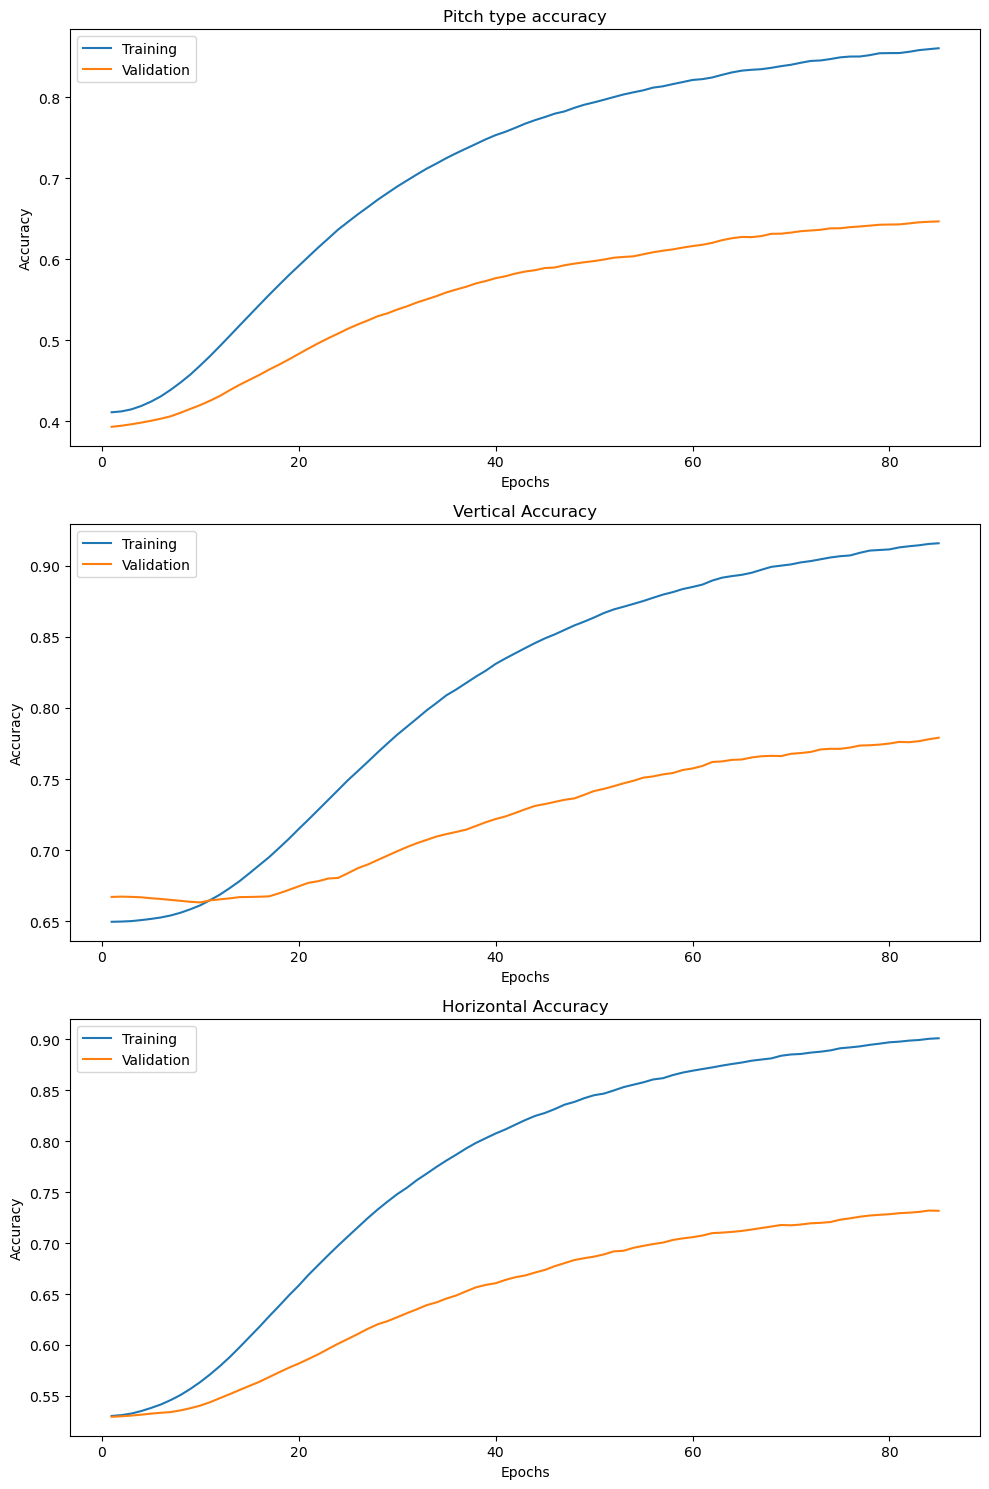

In [ ]:
plot_ensemble_history(history)

We can see a good performance in the validation set after training using the FreezeOutputCallback. We see no signs of overfitting which is good, however, we notice a plateau in the validation accuracy by the time training is halted by the callback. We will implement regularization techniques to see if we can improve the model's performance.

### Regularization

In [19]:
freeze_output_callback = FreezeOutputCallback(patience=5)

regularizations = [tf.keras.regularizers.l1(0.001), tf.keras.regularizers.l2(0.001), tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)]
histories = []

for reg in regularizations:
    print("Testing with regularization:", reg)
    model = build_model(reg=reg)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories.append(history)

Testing with regularization: <keras.src.regularizers.regularizers.L1 object at 0x0000019BAA10D710>

Freezing output vertical at 8 epochs.

Freezing output horizontal at 59 epochs.

Freezing output pitch at 78 epochs.

All outputs frozen. Stopping training at epoch 78.
Testing with regularization: <keras.src.regularizers.regularizers.L2 object at 0x0000019B8129F410>

Freezing output vertical at 6 epochs.

Freezing output pitch at 50 epochs.

Freezing output horizontal at 58 epochs.

All outputs frozen. Stopping training at epoch 58.
Testing with regularization: <keras.src.regularizers.regularizers.L1L2 object at 0x0000019B8129DF50>

Freezing output vertical at 13 epochs.

Freezing output horizontal at 45 epochs.

Freezing output pitch at 63 epochs.

All outputs frozen. Stopping training at epoch 63.


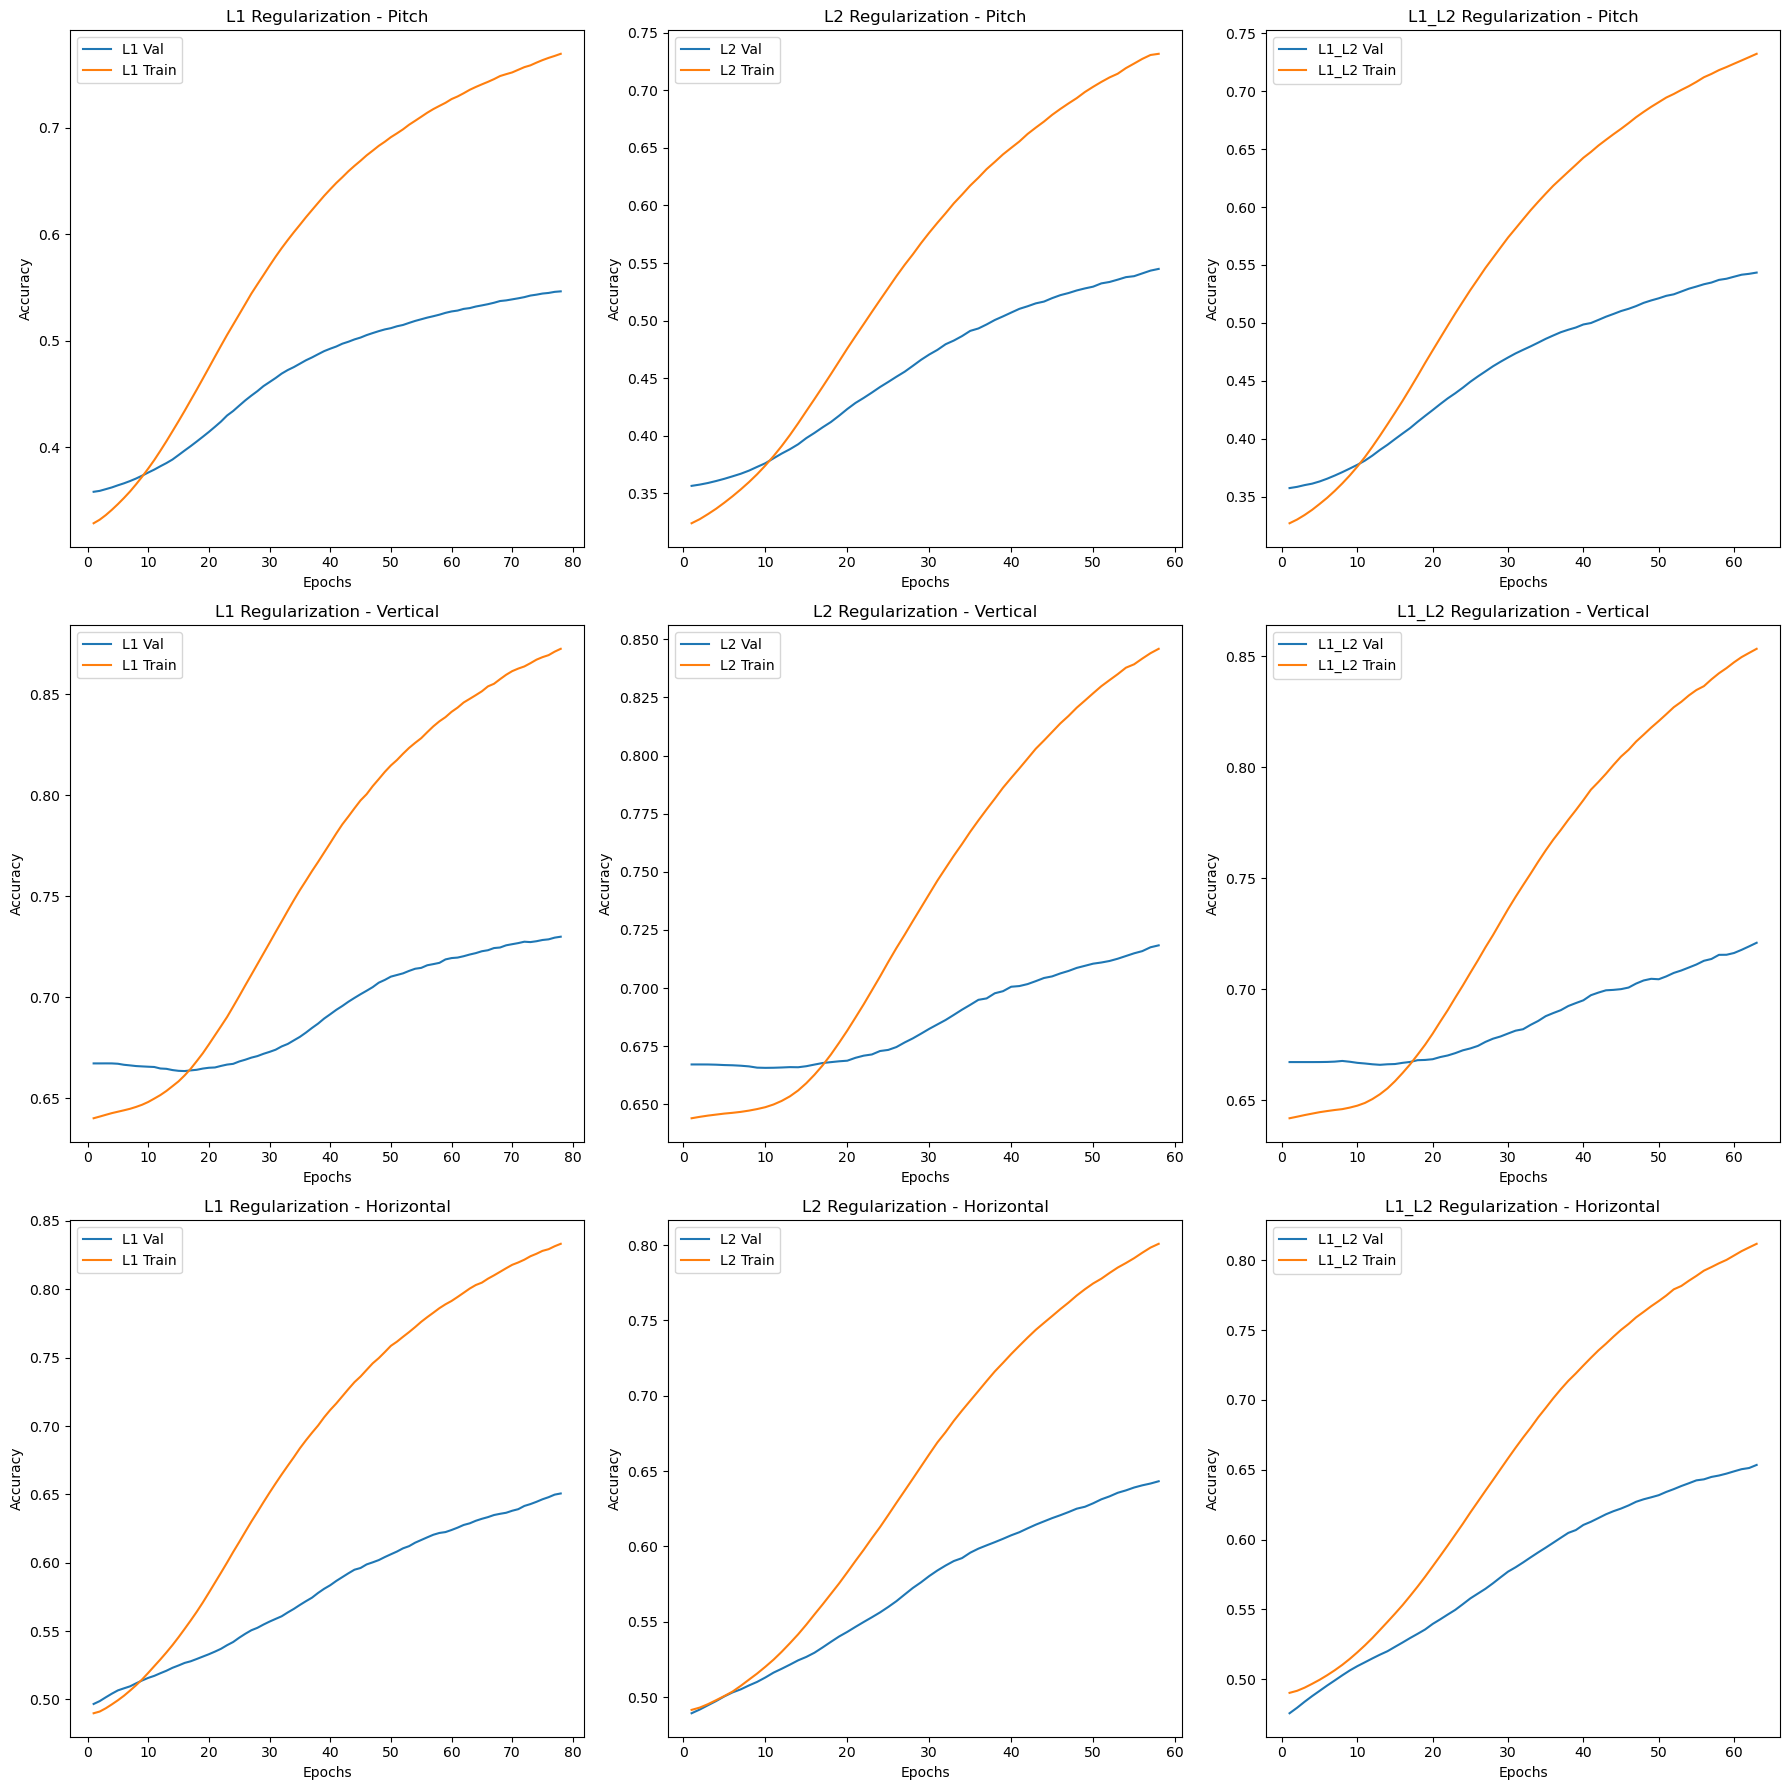

In [ ]:
# Smooth the curves for better visualization
smooth_l1_pitch_val = smooth_curve(histories[0].history['val_pitch_output_accuracy'])
smooth_l2_pitch_val = smooth_curve(histories[1].history['val_pitch_output_accuracy'])
smooth_l1_l2_pitch_val = smooth_curve(histories[2].history['val_pitch_output_accuracy'])

smooth_l1_pitch_train = smooth_curve(histories[0].history['pitch_output_accuracy'])
smooth_l2_pitch_train = smooth_curve(histories[1].history['pitch_output_accuracy'])
smooth_l1_l2_pitch_train = smooth_curve(histories[2].history['pitch_output_accuracy'])

smooth_l1_vertical_val = smooth_curve(histories[0].history['val_vertical_output_accuracy'])
smooth_l2_vertical_val = smooth_curve(histories[1].history['val_vertical_output_accuracy'])
smooth_l1_l2_vertical_val = smooth_curve(histories[2].history['val_vertical_output_accuracy'])

smooth_l1_vertical_train = smooth_curve(histories[0].history['vertical_output_accuracy'])
smooth_l2_vertical_train = smooth_curve(histories[1].history['vertical_output_accuracy'])
smooth_l1_l2_vertical_train = smooth_curve(histories[2].history['vertical_output_accuracy'])

smooth_l1_horizontal_val = smooth_curve(histories[0].history['val_horizontal_output_accuracy'])
smooth_l2_horizontal_val = smooth_curve(histories[1].history['val_horizontal_output_accuracy'])
smooth_l1_l2_horizontal_val = smooth_curve(histories[2].history['val_horizontal_output_accuracy'])

smooth_l1_horizontal_train = smooth_curve(histories[0].history['horizontal_output_accuracy'])
smooth_l2_horizontal_train = smooth_curve(histories[1].history['horizontal_output_accuracy'])
smooth_l1_l2_horizontal_train = smooth_curve(histories[2].history['horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot L1 regularization
axes[0, 0].plot(range(1, len(smooth_l1_pitch_val) + 1), smooth_l1_pitch_val, label='L1 Val')
axes[0, 0].plot(range(1, len(smooth_l1_pitch_train) + 1), smooth_l1_pitch_train, label='L1 Train')
axes[0, 0].set_title('L1 Regularization - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

axes[1, 0].plot(range(1, len(smooth_l1_vertical_val) + 1), smooth_l1_vertical_val, label='L1 Val')
axes[1, 0].plot(range(1, len(smooth_l1_vertical_train) + 1), smooth_l1_vertical_train, label='L1 Train')
axes[1, 0].set_title('L1 Regularization - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

axes[2, 0].plot(range(1, len(smooth_l1_horizontal_val) + 1), smooth_l1_horizontal_val, label='L1 Val')
axes[2, 0].plot(range(1, len(smooth_l1_horizontal_train) + 1), smooth_l1_horizontal_train, label='L1 Train')
axes[2, 0].set_title('L1 Regularization - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot L2 regularization
axes[0, 1].plot(range(1, len(smooth_l2_pitch_val) + 1), smooth_l2_pitch_val, label='L2 Val')
axes[0, 1].plot(range(1, len(smooth_l2_pitch_train) + 1), smooth_l2_pitch_train, label='L2 Train')
axes[0, 1].set_title('L2 Regularization - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 1].plot(range(1, len(smooth_l2_vertical_val) + 1), smooth_l2_vertical_val, label='L2 Val')
axes[1, 1].plot(range(1, len(smooth_l2_vertical_train) + 1), smooth_l2_vertical_train, label='L2 Train')
axes[1, 1].set_title('L2 Regularization - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

axes[2, 1].plot(range(1, len(smooth_l2_horizontal_val) + 1), smooth_l2_horizontal_val, label='L2 Val')
axes[2, 1].plot(range(1, len(smooth_l2_horizontal_train) + 1), smooth_l2_horizontal_train, label='L2 Train')
axes[2, 1].set_title('L2 Regularization - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

# Plot L1_L2 regularization
axes[0, 2].plot(range(1, len(smooth_l1_l2_pitch_val) + 1), smooth_l1_l2_pitch_val, label='L1_L2 Val')
axes[0, 2].plot(range(1, len(smooth_l1_l2_pitch_train) + 1), smooth_l1_l2_pitch_train, label='L1_L2 Train')
axes[0, 2].set_title('L1_L2 Regularization - Pitch')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()

axes[1, 2].plot(range(1, len(smooth_l1_l2_vertical_val) + 1), smooth_l1_l2_vertical_val, label='L1_L2 Val')
axes[1, 2].plot(range(1, len(smooth_l1_l2_vertical_train) + 1), smooth_l1_l2_vertical_train, label='L1_L2 Train')
axes[1, 2].set_title('L1_L2 Regularization - Vertical')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].legend()

axes[2, 2].plot(range(1, len(smooth_l1_l2_horizontal_val) + 1), smooth_l1_l2_horizontal_val, label='L1_L2 Val')
axes[2, 2].plot(range(1, len(smooth_l1_l2_horizontal_train) + 1), smooth_l1_l2_horizontal_train, label='L1_L2 Train')
axes[2, 2].set_title('L1_L2 Regularization - Horizontal')
axes[2, 2].set_xlabel('Epochs')
axes[2, 2].set_ylabel('Accuracy')
axes[2, 2].legend()

plt.tight_layout()
plt.show()

We do not see any considerable improvements by using regularization. Thus, we will not use it in the final model.

### Dropout

In [7]:
dropout_rates = [0, 0.5]
histories_dropout = []

for dropout_rate in dropout_rates:
    print("Testing with dropout rate:", dropout_rate)
    model = build_model(drop=dropout_rate)
    history = model.fit(X_train, 
                                 {'pitch_output': y_pitch_train,
                                  'vertical_output': y_vertical_train,
                                  'horizontal_output': y_horizontal_train},
                                 epochs=100, batch_size=64, 
                                 validation_data=(X_val, 
                                                  {'pitch_output': y_pitch_val,
                                                   'vertical_output': y_vertical_val,
                                                   'horizontal_output': y_horizontal_val}),
                                 callbacks=[freeze_output_callback],
                                 verbose=0
                                )
    histories_dropout.append(history)

Testing with dropout rate: 0

Freezing output vertical at 54 epochs.

Freezing output pitch at 68 epochs.

Freezing output horizontal at 69 epochs.

All outputs frozen. Stopping training at epoch 69.
Testing with dropout rate: 0.5

Freezing output vertical at 6 epochs.

Freezing output pitch at 15 epochs.

Freezing output horizontal at 37 epochs.

All outputs frozen. Stopping training at epoch 37.


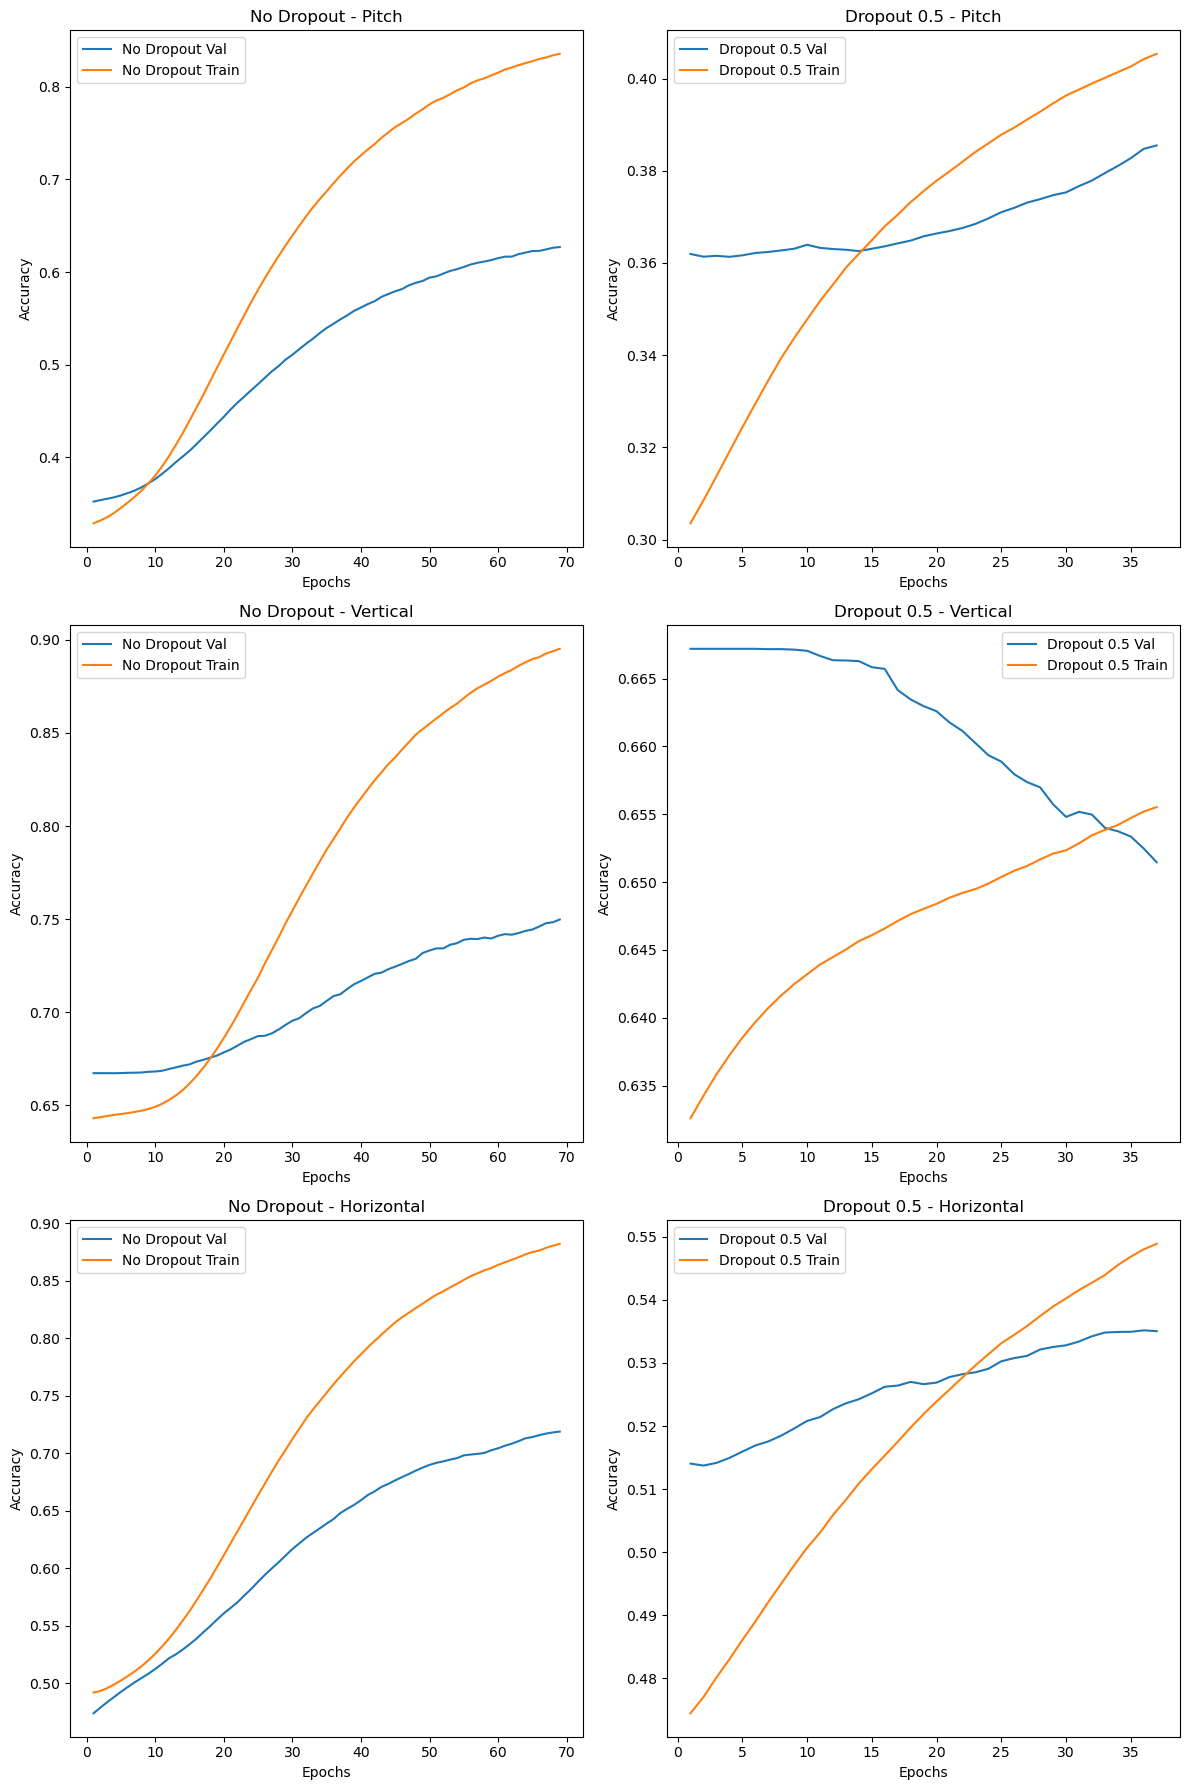

In [11]:
# Smooth the curves for better visualization
smooth_no_drop_pitch_val = smooth_curve(histories_dropout[0].history['val_pitch_output_accuracy'])
smooth_drop_05_pitch_val = smooth_curve(histories_dropout[1].history['val_pitch_output_accuracy'])
smooth_no_drop_pitch_train = smooth_curve(histories_dropout[0].history['pitch_output_accuracy'])
smooth_drop_05_pitch_train = smooth_curve(histories_dropout[1].history['pitch_output_accuracy'])

smooth_no_drop_vertical_val = smooth_curve(histories_dropout[0].history['val_vertical_output_accuracy'])
smooth_drop_05_vertical_val = smooth_curve(histories_dropout[1].history['val_vertical_output_accuracy'])
smooth_no_drop_vertical_train = smooth_curve(histories_dropout[0].history['vertical_output_accuracy'])
smooth_drop_05_vertical_train = smooth_curve(histories_dropout[1].history['vertical_output_accuracy'])

smooth_no_drop_horizontal_val = smooth_curve(histories_dropout[0].history['val_horizontal_output_accuracy'])
smooth_drop_05_horizontal_val = smooth_curve(histories_dropout[1].history['val_horizontal_output_accuracy'])
smooth_no_drop_horizontal_train = smooth_curve(histories_dropout[0].history['horizontal_output_accuracy'])
smooth_drop_05_horizontal_train = smooth_curve(histories_dropout[1].history['horizontal_output_accuracy'])

# Create a collage of plots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Plot without dropout for pitch
axes[0, 0].plot(range(1, len(smooth_no_drop_pitch_val) + 1), smooth_no_drop_pitch_val, label='No Dropout Val')
axes[0, 0].plot(range(1, len(smooth_no_drop_pitch_train) + 1), smooth_no_drop_pitch_train, label='No Dropout Train')
axes[0, 0].set_title('No Dropout - Pitch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot with 0.5 dropout for pitch
axes[0, 1].plot(range(1, len(smooth_drop_05_pitch_val) + 1), smooth_drop_05_pitch_val, label='Dropout 0.5 Val')
axes[0, 1].plot(range(1, len(smooth_drop_05_pitch_train) + 1), smooth_drop_05_pitch_train, label='Dropout 0.5 Train')
axes[0, 1].set_title('Dropout 0.5 - Pitch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot without dropout for vertical
axes[1, 0].plot(range(1, len(smooth_no_drop_vertical_val) + 1), smooth_no_drop_vertical_val, label='No Dropout Val')
axes[1, 0].plot(range(1, len(smooth_no_drop_vertical_train) + 1), smooth_no_drop_vertical_train, label='No Dropout Train')
axes[1, 0].set_title('No Dropout - Vertical')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Plot with 0.5 dropout for vertical
axes[1, 1].plot(range(1, len(smooth_drop_05_vertical_val) + 1), smooth_drop_05_vertical_val, label='Dropout 0.5 Val')
axes[1, 1].plot(range(1, len(smooth_drop_05_vertical_train) + 1), smooth_drop_05_vertical_train, label='Dropout 0.5 Train')
axes[1, 1].set_title('Dropout 0.5 - Vertical')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Plot without dropout for horizontal
axes[2, 0].plot(range(1, len(smooth_no_drop_horizontal_val) + 1), smooth_no_drop_horizontal_val, label='No Dropout Val')
axes[2, 0].plot(range(1, len(smooth_no_drop_horizontal_train) + 1), smooth_no_drop_horizontal_train, label='No Dropout Train')
axes[2, 0].set_title('No Dropout - Horizontal')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot with 0.5 dropout for horizontal
axes[2, 1].plot(range(1, len(smooth_drop_05_horizontal_val) + 1), smooth_drop_05_horizontal_val, label='Dropout 0.5 Val')
axes[2, 1].plot(range(1, len(smooth_drop_05_horizontal_train) + 1), smooth_drop_05_horizontal_train, label='Dropout 0.5 Train')
axes[2, 1].set_title('Dropout 0.5 - Horizontal')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


We see that dropout does not improve the model's performance. We will not use it in the final model.

## Final Model

The best hyperparameters for each output will be used to build the final model. No regularization techniques will be used.

In [12]:
# Test the build_model function
model = build_model()

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output vertical at 54 epochs.

Freezing output pitch at 68 epochs.

Freezing output horizontal at 69 epochs.

All outputs frozen. Stopping training at epoch 69.


In [13]:
max_pitch_val_accuracy = max(history.history['val_pitch_output_accuracy'])
max_vertical_val_accuracy = max(history.history['val_vertical_output_accuracy'])
max_horizontal_val_accuracy = max(history.history['val_horizontal_output_accuracy'])

print(f"Max Pitch Validation Accuracy: {max_pitch_val_accuracy}")
print(f"Max Vertical Validation Accuracy: {max_vertical_val_accuracy}")
print(f"Max Horizontal Validation Accuracy: {max_horizontal_val_accuracy}")

Max Pitch Validation Accuracy: 0.6440944671630859
Max Vertical Validation Accuracy: 0.7640420198440552
Max Horizontal Validation Accuracy: 0.7350393533706665


In [14]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - horizontal_output_accuracy: 0.7211 - loss: 3.3276 - pitch_output_accuracy: 0.6488 - vertical_output_accuracy: 0.7433
Pitch Test Accuracy: 0.7223097085952759
Vertical Test Accuracy: 0.647769033908844
Horizontal Test Accuracy: 0.7476378083229065
